In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 

from utils import get_tid,get_allowed_index_map

- Differences logging 9 and 10.
  - Logging error counts at different voltages.
- Associating pll df with scans df.

In [2]:
def parse_log(fname):
    _f = open(f'logs/{fname}')
    _fLines = _f.read()
    
    def find_match(re_string):
        return np.array(re.findall(re_string,_fLines))
    
    # readings on voltage,current,temp and resistance and error counts
    reading_matches = find_match(r'09-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n09.* Word count (\d*), error count (\d*)')
    reading_dates = pd.to_datetime(['09-'+x for x in reading_matches[:,0]])
    reading_voltage = np.float32(reading_matches[:,1])
    reading_current = np.float32(reading_matches[:,2])
    reading_temp = np.float32(reading_matches[:,3])
    reading_resistance = np.float32(reading_matches[:,4]) 
    reading_words = np.float32(reading_matches[:,5])
    reading_errors = np.float32(reading_matches[:,6])
    reading_error_rate = reading_errors/reading_words

    # replace bad-readings
    bad_readings = (reading_voltage==-1)&(reading_current==-1)
    reading_voltage[bad_readings]=np.nan
    reading_current[bad_readings]=np.nan
    bad_readings = (reading_temp==-1)&(reading_resistance==-1)
    reading_temp[bad_readings]=np.nan
    reading_resistance[bad_readings]=np.nan

    # check if previous readings match an i2c transaction
    i2c_matches = find_match(r'09-.* RW M.*\n09-(.*) INFO   Power: On, Voltage: (.*) V, Current: (.*) A, Temp: (.*) C, Res.: (.*) Ohms\n09.* Word count (\d*), error count (\d*)')
    if len(i2c_matches)>0:
        i2c_dates = pd.to_datetime(['09-'+x for x in i2c_matches[:,0]])
        is_i2c = reading_dates.isin(i2c_dates)
    else:
        is_i2c = np.full(reading_dates.shape, False)
    
    # TID
    reading_tid = get_tid(reading_dates.values,board)
    
    # pll setting that was actually used
    pll_good_matches = find_match('09-(.*) INFO   Setting PLL VCO CapSelect to (\d*) with phaseSelect settings of (\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*),(\d*)')
    pll_setting = pll_good_matches[:,1]
    pll_setting_phase = pll_good_matches[:,2:].tolist()

    # pll scans timestamp
    pll_timestamp_matches = find_match('09-(.*) INFO   Starting Power Scans \( timestamp (.*) \)')
    timestamp = pll_timestamp_matches[:,1]

    # pll scans, extract, dates, settings and pusm
    def extract_pll_info(pll_set_matches):
        pll_dates = []
        pll_settings = []
        pll_voltages = []
        pll_pusm = []
        pll_good = []
        pll_third = []
    
        pusm = []
        settings = []
        good = []
        for m in pll_set_matches:
            if not m[0]=='':
                # the rows that start with the date only contain the time at the start of the scan and voltage
                pll_dates.append('09-'+m[0])
                pll_voltages.append(float(m[1]))
                if len(pusm) > 0:
                    pll_pusm.append(np.array(pusm))
                    pll_settings.append(np.array(settings))
                    pll_good.append(np.array(good))
                    pll_third.append(good[int(len(good)/3)])
                    pusm = []
                    settings = []
                    good = []
            else:
                pusm.append(int(m[-1]))
                settings.append(int(m[-3]))
                if int(m[-1]) == 9:
                    good.append(int(m[-3]))
                
        # use this for the last row
        pll_pusm.append(np.array(pusm))
        pll_settings.append(np.array(settings))
        pll_good.append(np.array(good))
        pll_third.append(good[int(len(good)/3)])
        
        return pll_dates,pll_settings,pll_voltages,pll_pusm,pll_good,pll_third
                    
    pll_set_matches = find_match("09-(.*) INFO   Good PLL settings V=(.*):|09-(.*) INFO.     CapSel=(\d+), V=(.*), PUSM=(\d)")
    pll_dates,pll_settings,pll_voltages,pll_pusm,pll_good,pll_third = extract_pll_info(pll_set_matches)

    pll_df = pd.DataFrame(pll_voltages, columns=['voltage'])
    
    # triplicate the timestamp for all voltages
    # probably won't need to do this for chip 9
    def triplicate(arr):
        return [val for val in arr for _ in (0, 1, 2)]
    
    pll_df['timestamp'] = triplicate(timestamp)
    pll_df['cb_settings'] = pd.Series(pll_good)
    pll_df['cb_pusm'] = pd.Series(pll_pusm)
    
    # good settings
    pll_df['ngood'] = pll_df.cb_settings.apply(lambda x: len(x))
    pll_df['maxgood'] = pll_df.cb_settings.apply(lambda x: max(x))
    pll_df['mingood'] = pll_df.cb_settings.apply(lambda x: min(x))
    
    pll_df['third'] = pll_third
    pll_df['third_index'] = pll_df.third.apply(lambda x: get_allowed_index_map(x))

    pll_df['used'] = np.int32(triplicate(pll_setting))
    pll_df['used_index'] = pll_df.used.apply(lambda x: get_allowed_index_map(x))
    pll_df['used_phases'] = triplicate(np.int32(pll_setting_phase))

    # fill dataframe
    output = {}
    output['time']=reading_dates
    output['TID']=reading_tid
    output['voltage']=reading_voltage
    output['current']=reading_current
    output['temp']=reading_temp
    output['rtd']=reading_resistance
    output['nComp']=reading_words
    output['nErr']=reading_errors
    output['isI2C']=is_i2c
    
    df = pd.DataFrame.from_dict(output)
    #df['PLLscan_bestPhase'] = pll_good_matches[:,2:].tolist()

    return  df,pll_df

In [29]:
board = '10'
log_strs = {
    '10': [#'logFile_Chip10_CoolDown.log',
           'logFile_Chip10_StartIrradiation.log',
           'logFile_Chip10_StartIrradiation_Sept28_05h28.log',
           'logFile_Chip10_StartIrradiation_Sept28_05h58.log',
           'logFile_Chip10_StartIrradiation_Sept28_07h05.log',
           'logFile_Chip10_StartIrradiation_Sept28_07h23.log',
           'logFile_Chip10_StartIrradiation_Sept28_14h14.log',
           'logFile_Chip10_StartIrradiation_Sept28_16h43.log',
           'logFile_Chip10_StartIrradiation_Sept28_16h59.log',
           'logFile_Chip10_StartIrradiation_Sept28_17h19.log',
           'logFile_Chip10_StartIrradiation_Sept28_20h16.log',
          ],
    '9': ['logFile_Chip09_CoolDown.log',
          'logFile_Chip09_Oct2_09h48_StartIrradiation.log',
          'logFile_Chip09_Oct2_12h26_StartIrradiation.log',
          'logFile_Chip09_Oct2_12h58_StartIrradiation.log',
          'logFile_Chip09_Oct2_19h03_StartIrradiation.log',
          'logFile_Chip09_Oct3_11h33_StartIrradiation.log',
          'logFile_Chip09_Oct3_12h16_StartIrradiation.log',
         ]
}[board]

parsed_logs = [parse_log(lname) for lname in log_strs]
df_irr = pd.concat([p[0] for p in parsed_logs])

df_pll = pd.concat([p[1] for p in parsed_logs])

In [31]:
df_pll.columns

Index(['voltage', 'timestamp', 'cb_settings', 'cb_pusm', 'ngood', 'maxgood',
       'mingood', 'third', 'third_index', 'used', 'used_index', 'used_phases'],
      dtype='object')

In [30]:
df_irr.columns

Index(['time', 'TID', 'voltage', 'current', 'temp', 'rtd', 'nComp', 'nErr',
       'isI2C'],
      dtype='object')

Plot Temperature and Current as a function of time

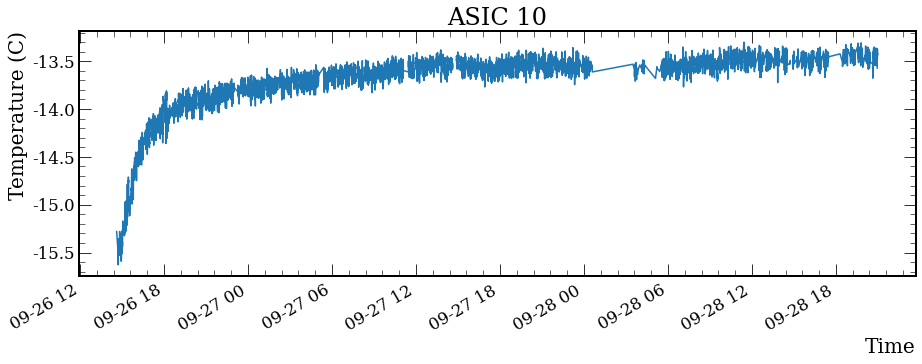

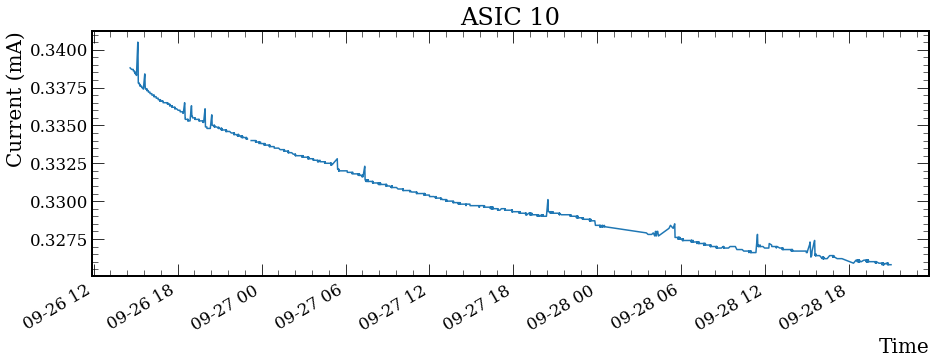

In [20]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(df_irr.time,df_irr.temp)
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (C)');
ax.set_title(f'ASIC {board}')
fig.autofmt_xdate()

fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(df_irr.time,df_irr.current)
ax.set_xlabel('Time')
ax.set_ylabel('Current (mA)');
ax.set_title(f'ASIC {board}')
fig.autofmt_xdate()

Plot Temperature and Current as a function of TID

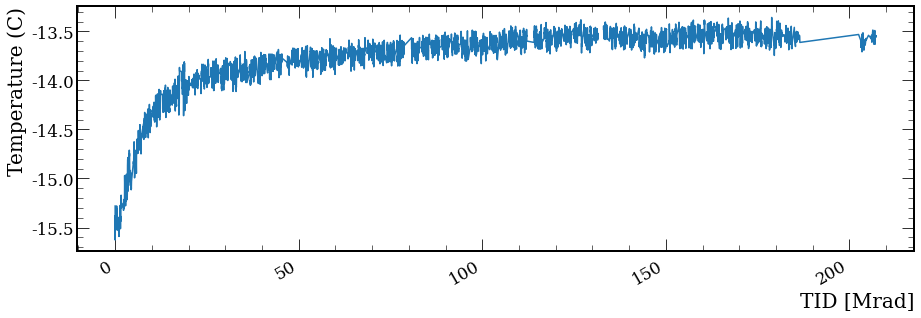

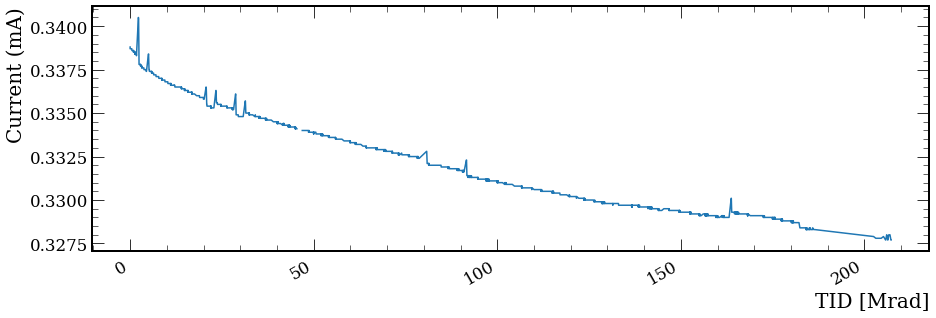

In [10]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(df_irr.TID,df_irr.temp)
ax.set_xlabel('TID [Mrad]')
ax.set_ylabel('Temperature (C)');
ax.set_title(f'ASIC {board}')
fig.autofmt_xdate()

fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(df_irr.TID,df_irr.current)
ax.set_xlabel('TID [Mrad]')
ax.set_ylabel('Current (mA)');
ax.set_title(f'ASIC {board}')
fig.autofmt_xdate()

Plot i2c Comparison Errors as a function of Time

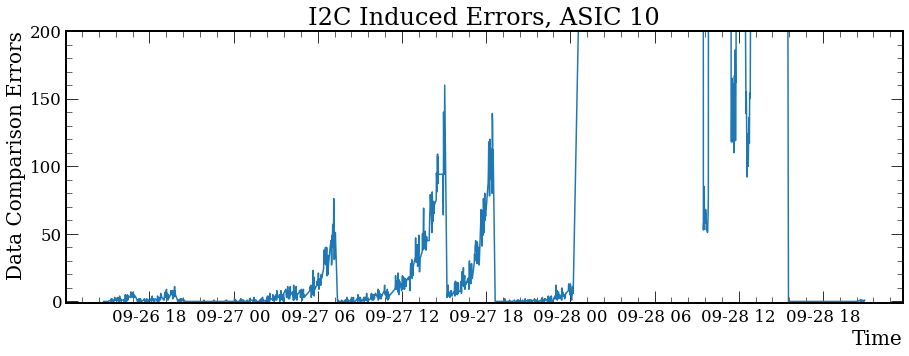

In [24]:
#print(df_irr.nErr/df_irr.nComp)
  
d = df_irr.loc[df_irr.isI2C]
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(d.time,d.nErr)
ax.set_xlabel('Time')
ax.set_ylabel('Data Comparison Errors')
ax.set_title(f'I2C Induced Errors, ASIC {board}')
ax.set_ylim(-1,200);

Plot PLL CapBank Choice or Used as a function of time/TID

Text(0.5, 1.0, 'Index from 1/3 choice ASIC 10')

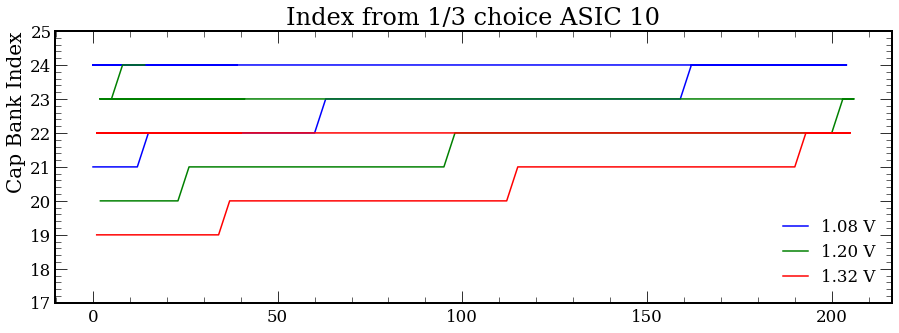

In [25]:
x = df_pll
fig,ax=plt.subplots(1,1,figsize=(15,5))
x[x.voltage==1.08].plot(y='third_index',ax=ax,color='blue',label='1.08 V')
x[x.voltage==1.2].plot(y='third_index',ax=ax,color='green',label='1.20 V')
x[x.voltage==1.32].plot(y='third_index',ax=ax,color='red',label='1.32 V')
ax.set_ylabel('Cap Bank Index')
ax.set_ylim(17,25)
ax.set_title(f'Index from 1/3 choice ASIC {board}')

Text(0.5, 1.0, 'Index used, ASIC 10')

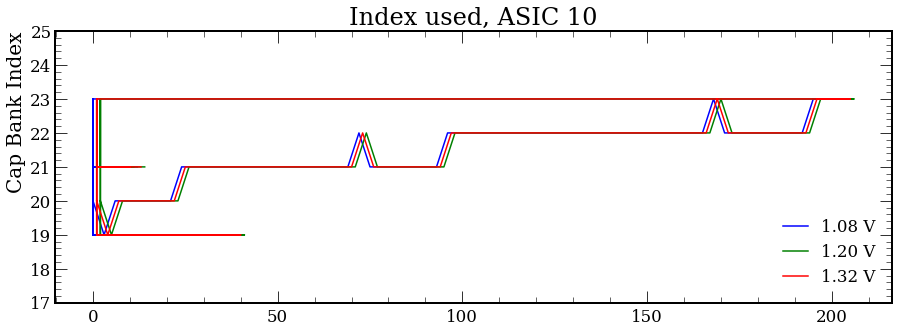

In [27]:
x = df_pll
fig,ax=plt.subplots(1,1,figsize=(15,5))
x[x.voltage==1.08].plot(y='used_index',ax=ax,color='blue',label='1.08 V')
x[x.voltage==1.2].plot(y='used_index',ax=ax,color='green',label='1.20 V')
x[x.voltage==1.32].plot(y='used_index',ax=ax,color='red',label='1.32 V')
ax.set_ylabel('Cap Bank Index')
ax.set_ylim(17,25)
ax.set_title(f'Index used, ASIC {board}')